In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
x_data=np.load('/kaggle/input/homework2/x_train.npy')
y_data=np.load('/kaggle/input/homework2/y_train.npy')
labels= tfk.utils.to_categorical(y_data, num_classes=12)
x_train, x_valid, y_train, y_valid= train_test_split(x_data, labels, test_size=0.2, shuffle=True, stratify= labels)

In [4]:
input_shape = x_train.shape[1:]
classes = 12
batch_size = 8
epochs = 200
input_shape


(36, 6)

In [5]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(200,6,padding='same',activation='relu')(input_layer) 
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(200,6,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 200)           7400      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 200)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 200)           240200    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               25728 

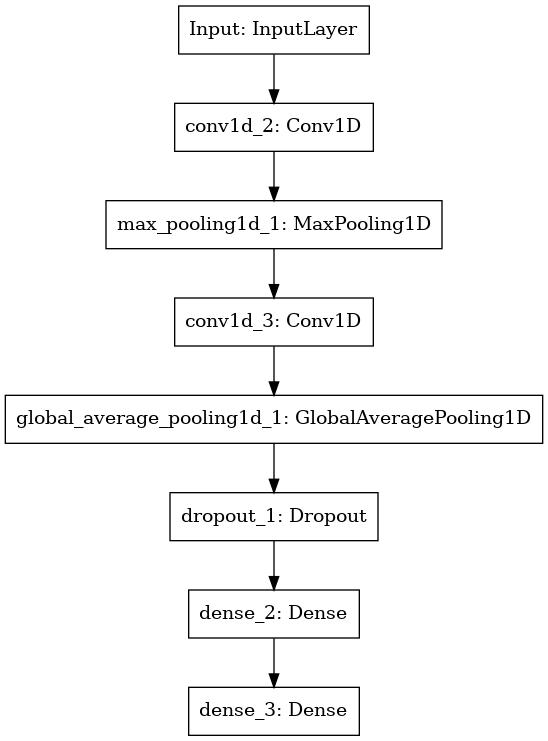

In [7]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()
tf.keras.utils.model_r(
    model,
    to_file='model.jpg')

In [16]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_valid, y_valid),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
243/243 [==============================] - 2s 5ms/step - loss: 21.9180 - accuracy: 0.1781 - val_loss: 4.8079 - val_accuracy: 0.3066
Epoch 2/200
243/243 [==============================] - 1s 6ms/step - loss: 3.7137 - accuracy: 0.3139 - val_loss: 2.3729 - val_accuracy: 0.3457
Epoch 3/200
243/243 [==============================] - 1s 4ms/step - loss: 2.3894 - accuracy: 0.3634 - val_loss: 2.3608 - val_accuracy: 0.3560
Epoch 4/200
243/243 [==============================] - 1s 4ms/step - loss: 2.2106 - accuracy: 0.3556 - val_loss: 2.1471 - val_accuracy: 0.3786
Epoch 5/200
243/243 [==============================] - 1s 4ms/step - loss: 2.2648 - accuracy: 0.3644 - val_loss: 2.1070 - val_accuracy: 0.3642
Epoch 6/200
243/243 [==============================] - 1s 4ms/step - loss: 2.1328 - accuracy: 0.3726 - val_loss: 2.9633 - val_accuracy: 0.3580
Epoch 7/200
243/243 [==============================] - 1s 4ms/step - loss: 2.0988 - accuracy: 0.3690 - val_loss: 1.9534 - val_accuracy: 0.390

In [17]:
model.save('modello')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6872
Precision: 0.6502
Recall: 0.5086
F1: 0.5455


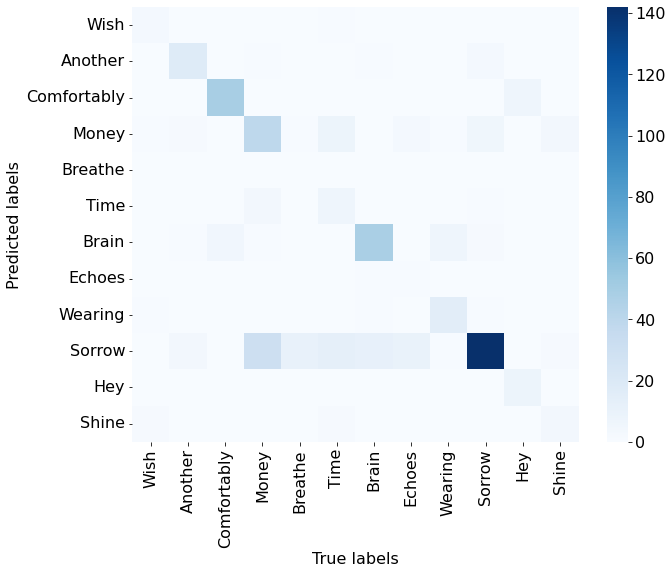

In [18]:
the_labels = {
0: "Wish",
1: "Another",
2: "Comfortably",
3: "Money",
4: "Breathe",
5: "Time",
6: "Brain",
7: "Echoes",
8: "Wearing",
9: "Sorrow",
10: "Hey",
11: "Shine"
}

predictions = model.predict(x_valid)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_valid, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_valid, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_valid, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_valid, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_valid, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(the_labels.values()), yticklabels=list(the_labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()